In [44]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings

warnings.filterwarnings("ignore")

from numpy.testing import assert_array_equal

import sklearn
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedShuffleSplit,
    cross_validate,
)
import matplotlib.pyplot as plt

from sklearn.utils import resample

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

# if you installed sporf via README
#from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

from episcalp.cross_validate import get_X_features, load_derived_datasets, _compute_spike_rates
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder

from sample_code.features import (
    get_spike_rate,
    get_max_spike_rate,
    get_lobe_spike_rate,
)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
y_enc = LabelEncoder()

In [4]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [5]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 1,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

# Define possible helper functions

In [6]:
def _preprocess_epochs_tfr(data):
    assert data.ndim == 4

    # take the average over frequencies
    data = np.mean(data, axis=2)

    # move the epoch ("window") axis to last
    data = np.moveaxis(data, 0, -2)

    # compress the time axis
    data = np.mean(data, axis=-1)

    # convert to dB
    data = 20 * np.log10(data)

    data = np.reshape(data, (data.shape[0], -1))
    return data

In [48]:
def _load_subject_spikes(root, subjects=None, search_str = "*.edf", threshold=0.4):
    if subjects is None:
        subjects = get_entity_vals(root, "subject")

    print(f"Loading data for subjects: {subjects}")

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = root / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.rglob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            entities = get_entities_from_fname(fpath.name)
            bids_path = BIDSPath(root=root, datatype="eeg",
                                extension='.edf', **entities)
            raw = read_raw_bids(bids_path)

            # extract data
            ch_spike_rates = _compute_spike_rates(raw, threshold=threshold)

            # normalize spike counts
            for ch_name, val in ch_spike_rates.items():
                ch_spike_rates[ch_name] = val / (raw.n_times / raw.info["sfreq"])

            # total spike rate = total # of spikes regardless of channel / times / n_chs
            total_spike_rate = (
                np.sum(list(ch_spike_rates.values()))
                / len(raw.ch_names)
                / (raw.n_times / raw.info["sfreq"])
            )

            # max spike per lobe
            ch_spikes = np.array(list(ch_spike_rates.values()))
            lobe_dict = _standard_lobes(separate_hemispheres=False)

            # value of the max spike rate
            features = np.hstack(
                (
                    ch_spikes.mean(),
                    ch_spikes.std(),
                    np.quantile(ch_spikes, q=0.1),
                    np.quantile(ch_spikes, q=0.5),
                    np.quantile(ch_spikes, q=0.9),
                    total_spike_rate,
                )
            )
            ch_names = raw.ch_names

            assert len(ch_names) == len(ch_spike_rates.keys())
            assert_array_equal(ch_names, list(ch_spike_rates.keys()))

            dataset["data"].append(features)
            dataset["subject"].append(subject)
            dataset["session"].append(entities["session"])
            dataset["task"].append(entities["task"])
            dataset["run"].append(entities["run"])
            dataset["ch_names"].append(ch_names)
            dataset['roots'].append(root)
    return dataset

In [8]:
def _load_subject_derivs(deriv_path, read_func, subjects=None, ignore_fpaths=None, search_str="*.npy"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)
    
    this_path = deriv_path
    while this_path.parent.name != 'derivatives' and this_path.parent.name != '/':
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            entities = get_entities_from_fname(fpath.name, on_error='ignore')
            ignore=False
            if ignore_fpaths is None:
                ignore_fpaths = []
            for f in ignore_fpaths:
                if f in str(fpath):
                    print(f"Skipping fpath: {fpath}")
                    ignore=True
            if not ignore:
                deriv = read_func(fpath, source_check=False)

                # extract data
                ch_names = deriv.ch_names
                deriv_data = deriv.get_data()

                dataset["subject"].append(subject)
                dataset["session"].append(entities["session"])
                dataset["task"].append(entities["task"])
                dataset["run"].append(entities["run"])
                dataset["data"].append(deriv_data)
                dataset["ch_names"].append(ch_names)
                dataset['roots'].append(root)

    return dataset

In [9]:
def _load_subject_tfrs(deriv_path, read_func, subjects=None, ignore_fpaths=None, search_str="*.h5"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)
    
    this_path = deriv_path
    while this_path.parent.name != 'derivatives' and this_path.parent.name != '/':
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            entities = get_entities_from_fname(fpath.name, on_error='ignore')
            ignore=False
            if ignore_fpaths is None:
                ignore_fpaths = []
            for f in ignore_fpaths:
                if f in str(fpath):
                    print(f"Skipping fpath: {fpath}")
                    ignore=True
            if not ignore:
                deriv = read_func(fpath)[0]

                # extract data
                ch_names = deriv.ch_names
                deriv_data = deriv.data

                # apply mean across axis 2
                deriv_data = _preprocess_epochs_tfr(deriv_data)
    #             deriv_data = np.mean(deriv_data, axis=2)
                ch_names, deriv_data = removeC3C4(ch_names, deriv_data)
                
                dataset["subject"].append(subject)
                dataset["session"].append(entities["session"])
                dataset["task"].append(entities["task"])
                dataset["run"].append(entities["run"])
                dataset["data"].append(deriv_data)
                dataset["ch_names"].append(ch_names)
                dataset['roots'].append(root)

    return dataset

In [10]:
def combine_datasets(dataset1, dataset2):
    dataset = dataset1
    for idx, subject in enumerate(dataset1["subject"]):
        for jdx, subject2 in enumerate(dataset2["subject"]):
            if subject == subject2:
                data = list(dataset1["data"][idx])
                print(data)
                data.extend(list(dataset2["data"][jdx]))
                print(data)
                dataset["data"][idx] = np.array(data)
    return dataset

In [11]:
def add_spike_features(curr_X, spike_dataset):
    spike_data = np.array(spike_dataset["data"])
    print(spike_data.shape, spike_data)
    X = np.hstack((curr_X, spike_data))
    return X

In [12]:
def removeC3C4(chnames, data):
    chnames = np.array(chnames)
    data = np.array(data)
    keep_idx = []
    for idx, ch in enumerate(chnames):
        if ch not in ['C3', 'C4']:
            keep_idx.append(idx)
    chnames = chnames[keep_idx]
    data = data[keep_idx, :]
    return chnames, data

In [13]:
def _spike_features_from_dict(spike_dict):
    spike_rate = get_spike_rate(spike_dict)
    max_spike_rate = get_max_spike_rate(spike_dict)
    parietal_lobe_spike_rate = get_lobe_spike_rate(spike_dict, 'parietal')
    temporal_lobe_spike_rate = get_lobe_spike_rate(spike_dict, 'temporal')
    occipital_lobe_spike_rate = get_lobe_spike_rate(spike_dict, 'occipital')
    frontal_lobe_spike_rate = get_lobe_spike_rate(spike_dict, 'frontal')
    features = [spike_rate, max_spike_rate, parietal_lobe_spike_rate, temporal_lobe_spike_rate, occipital_lobe_spike_rate, frontal_lobe_spike_rate]
    return features

# Define data directories

In [14]:
jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

# not ready yet
upmcroot = Path("D:/OneDriveParent/Johns Hopkins/UPMC_Scalp - Documents/scalp_study/root")

In [15]:
reference = "monopolar"
radius = "1.25"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference
spike_deriv_chain = Path("spikes")

delta_tfr_deriv_chain = Path("tfr") / 'delta'
theta_tfr_deriv_chain = Path("tfr") / 'theta'
alpha_tfr_deriv_chain = Path("tfr") / 'alpha'
beta_tfr_deriv_chain = Path("tfr") / 'beta'

In [16]:
root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"
combined_deriv_dir = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Scalp_EEG_combined")

# Load Feature Spatiotemporal Heatmap Datasets

In [178]:
threshold=0.9
exp_name = f"spikes_jhhjeff_{threshold}"

In [19]:
roots = [jhroot, jeffroot]
deriv_chains = [frag_deriv_chain, frag_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = '*desc-perturbmatrix*.npy'

# load fragility dataset
fragility_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh001\sub-jhh001_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh002\sub-jhh002_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh003\sub-jhh003_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh004\sub-jhh004_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh005\sub-jhh005_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh006\sub-jhh006_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh007\sub-jhh007_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh008\sub-jhh008_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh009\sub-jhh009_run-01_desc-perturbmatrix_eeg.json


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh010\sub-jhh010_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh011\sub-jhh011_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh012\sub-jhh012_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh013\sub-jhh013_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh014\sub-jhh014_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh015\sub-jhh015_run-01_desc-perturbmatrix_eeg.json
D:\OneDriv

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh017\sub-jhh017_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh018\sub-jhh018_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh019\sub-jhh019_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh020\sub-jhh020_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh021\sub-jhh021_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh022\sub-jhh022_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh023\sub-jhh023_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh024\sub-jhh024_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh025\sub-jhh025_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh026\sub-jhh026_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh027\sub-jhh027_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh027\sub-jhh027_task-awake_run-02_desc-perturbmat

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh030\sub-jhh030_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh101\sub-jhh101_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh102\sub-jhh102_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh103\sub-jhh103_run-01_desc-

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\epi

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh105\sub-jhh105_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh106\sub-jhh106_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh107\sub-jhh107_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh108\sub-jhh108_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh109\sub-jhh109_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh110\sub-jhh110_run-01_desc-perturbmatrix_eeg.json
D:\OneDriv

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh112\sub-jhh112_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh113\sub-jhh113_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh114\sub-jhh114_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh115\sub-jhh115_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh116\sub-jhh116_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh117\sub-jhh117_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh118\sub-jhh118_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh119\sub-jhh119_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh120\sub-jhh120_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh121\sub-jhh121_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh122\sub-jhh122_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh124\sub-jhh124_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh127\sub-jhh127_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh128\sub-jhh128_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh201\sub-jhh201_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh202\sub-jhh202_

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh204\sub-jhh204_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh205\sub-jhh205_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh206\sub-jhh206_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh207\sub-jhh207_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh208\sub-jhh208_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh209\sub-jhh209_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh210\sub-jhh210_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh211\sub-jhh211_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh212\sub-jhh212_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh213\sub-jhh213_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh214\sub-jhh214_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh215\sub-jhh215_run-01_desc-perturbmatrix_eeg.json
D:\OneDriv

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh217\sub-jhh217_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh218\sub-jhh218_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh219\sub-jhh219_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh220\sub-jhh220_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh221\sub-jhh221_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh222\sub-jhh222_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh223\sub-jhh223_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh224\sub-jhh224_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh225\sub-jhh225_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh226\sub-jhh226_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh227\sub-jhh227_run-01_desc-perturbmatrix_eeg.json
D:\OneDriv

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh229\sub-jhh229_task-awake_run-01_desc-perturbmatrix_eeg.json
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff001\sub-jeff001_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff001\sub-jeff001_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff002\sub-jeff002_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-4_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_ru

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-6_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-4_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff204\sub-jeff204_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff207\sub-jeff207_ses-1_run-1_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-2_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff209\sub-jeff209_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff210\sub-jeff210_ses-1_ru

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

In [94]:
roots = [jhroot, jeffroot]
deriv_chains = [ss_deriv_chain, ss_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = '*desc-ssindmatrix*.npy'

# load fragility dataset
sourcesink_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar
D:\OneDrivePar

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh007\sub-jhh007_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh008\sub-jhh008_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh009\sub-jhh009_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh010\sub-jhh010_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh011\sub-jhh011_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh012\sub-jhh012_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh013\sub-jhh013_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh014\sub-jhh014_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh015\sub-jhh015_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh016\sub-jhh016_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh017\sub-jhh017_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh018\sub-jhh018_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh019\sub-jhh019_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh020\sub-jhh020_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh021\sub-jhh021_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh022\sub-jhh022_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh023\sub-jhh023_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh024\sub-jhh024_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh025\sub-jhh025_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh026\sub-jhh026_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh027\sub-jhh027_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh027\sub-jhh027_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh030\sub-jhh030_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh101\sub-jhh101_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh102\sub-jhh102_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh103\sub-jhh103_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh104\sub-jhh104_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh105\sub-jhh105_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh106\sub-jhh106_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh107\sub-jhh107_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh108\sub-jhh108_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh109\sub-jhh109_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourc

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh112\sub-jhh112_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh113\sub-jhh113_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh114\sub-jhh114_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh115\sub-jhh115_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh116\sub-jhh116_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh117\sub-jhh117_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh118\sub-jhh118_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh119\sub-jhh119_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh120\sub-jhh120_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh121\sub-jhh121_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourc

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh127\sub-jhh127_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDrivePar

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh201\sub-jhh201_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh202\sub-jhh202_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh203\sub-jhh203_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh204\sub-jhh204_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh205\sub-jhh205_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh206\sub-jhh206_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourc

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh211\sub-jhh211_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh212\sub-jhh212_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh213\sub-jhh213_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh214\sub-jhh214_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh215\sub-jhh215_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh216\sub-jhh216_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh217\sub-jhh217_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh218\sub-jhh218_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh219\sub-jhh219_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh220\sub-jhh220_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh221\sub-jhh221_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh222\sub-jhh222_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh223\sub-jhh223_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh224\sub-jhh224_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh225\sub-jhh225_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh226\sub-jhh226_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh227\sub-jhh227_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh228\sub-jhh228_task-asleep_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh228\sub-jhh228_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh229\sub-jhh229_task-awake_run-01_desc-ssindmatrix_eeg.json
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff001\sub-jeff001_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff001\sub-jeff001_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivat

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff101\sub-jeff101_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-4_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferso

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferso

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff207\sub-jeff207_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferso

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

# Load TFR Heatmaps

In [95]:
roots = [jhroot, jeffroot]
deriv_chains = [delta_tfr_deriv_chain, delta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'

# load fragility dataset
delta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\delta
Loading data for subjects

In [96]:
roots = [jhroot, jeffroot]
deriv_chains = [theta_tfr_deriv_chain, theta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'

# load fragility dataset
theta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\theta
Loading data for subjects

In [97]:
roots = [jhroot, jeffroot]
deriv_chains = [alpha_tfr_deriv_chain, alpha_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'


# load fragility dataset
alpha_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\alpha
Loading data for subjects

In [98]:
roots = [jhroot, jeffroot]
deriv_chains = [beta_tfr_deriv_chain, beta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'

# load fragility dataset
beta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\beta


KeyError: "Can't open attribute (can't locate attribute: 'TITLE')"

In [179]:
def _convert_list_to_collection(deriv_dataset):
    # convert to a dictionary of lists
    derived_dataset = {key: [] for key in deriv_dataset[0].keys()}
    for deriv in deriv_dataset:
        for key in derived_dataset.keys():
            derived_dataset[key].extend(deriv[key])

    return derived_dataset

roots = [jhroot, jeffroot]

dataset_list = []
for root in roots:
    print('Getting spikes for', root)
    spike_dataset = _load_subject_spikes(root, threshold=threshold)
    dataset_list.append(spike_dataset)

print('Done...')
spikes_dataset = _convert_list_to_collection(dataset_list)

Getting spikes for D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids
Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
Events fname: D:\OneDrivePar

Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh019\eeg\sub-jhh019_run-01_events.tsv
Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:00:04     0.155       Spike    (F8,)        0.24
1  1970-01-01 00:00:18     0.120       Spike   (Fp2,)        0.44
2  1970-01-01 00:00:19     0.090       Spike    (T5,)        0.72
3  1970-01-01 00:00:25     0.325       Spike   (Fp2,)        0.34
4  1970-01-01 00:00:26     0.175       Spike   (Fp1,)        0.65
..                 ...       ...         ...      ...         ...
60 1970-01-01 00:12:54     0.125       Spike   (Fp2,)        0.45
61 1970-01-01 00:13:07     0.105       Spike    (F8,)        0.44
62 1970-01-01 00:13:09     0.310       Spike   (Fp2,)        0.27
63 1970-01-01 00:13:18     0.195       Spike   (Fp2,)        0.13
64 1970-01-01 00:13:38     0.115       Spike    (F8,)        0.41

[65 rows x 5 columns]
After subsetting:                  onset  d

16 1970-01-01 00:13:06     0.095       Spike    (F7,)        0.95
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh108\eeg\sub-jhh108_run-01_events.tsv
Before subsetting:                 onset  duration description ch_names  perception
0 1970-01-01 00:01:21     0.115       Spike    (T6,)        0.13
1 1970-01-01 00:11:30     0.105       Spike    (T4,)        0.96
2 1970-01-01 00:13:32     0.195       Spike    (T4,)        0.47
3 1970-01-01 00:14:42     0.100       Spike    (O1,)        0.35
After subsetting:                 onset  duration description ch_names  perception
1 1970-01-01 00:11:30     0.105       Spike    (T4,)        0.96
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh109\eeg\sub-jhh109_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh110\eeg\sub-jhh110_run-01_events.tsv
Before subsetting:                   onset  duration description ch_names

Index: []
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh119\eeg\sub-jhh119_run-01_events.tsv
Before subsetting:                 onset  duration description ch_names  perception
0 1970-01-01 00:00:10     0.235       Spike    (T6,)        0.24
1 1970-01-01 00:05:39     0.110       Spike    (F3,)        0.68
2 1970-01-01 00:07:30     0.100       Spike    (F8,)        0.45
3 1970-01-01 00:08:16     0.235       Spike    (P3,)        0.17
4 1970-01-01 00:09:50     0.150       Spike    (T6,)        0.11
5 1970-01-01 00:10:11     0.120       Spike    (T6,)        0.16
6 1970-01-01 00:10:16     0.120       Spike    (T6,)        0.15
7 1970-01-01 00:10:26     0.085       Spike    (F3,)        0.26
8 1970-01-01 00:10:48     0.095       Spike    (T6,)        0.12
After subsetting: Empty DataFrame
Columns: [onset, duration, description, ch_names, perception]
Index: []
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh120\ee

Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:06:27     0.245       Spike   (Fp1,)        0.29
1  1970-01-01 00:09:42     0.200       Spike   (Fp1,)        0.12
2  1970-01-01 00:09:58     0.135       Spike    (F7,)        0.21
3  1970-01-01 00:10:06     0.100       Spike    (F7,)        0.21
4  1970-01-01 00:11:36     0.095       Spike    (T3,)        0.22
5  1970-01-01 00:12:08     0.095       Spike    (T3,)        0.83
6  1970-01-01 00:12:35     0.075       Spike    (T3,)        0.88
7  1970-01-01 00:12:40     0.215       Spike    (P3,)        0.76
8  1970-01-01 00:12:41     0.120       Spike    (T3,)        0.67
9  1970-01-01 00:12:44     0.160       Spike    (F7,)        0.99
10 1970-01-01 00:12:45     0.060       Spike    (T3,)        0.73
11 1970-01-01 00:12:46     0.190       Spike    (F7,)        1.00
12 1970-01-01 00:12:49     0.130       Spike    (F7,)        0.69
13 1970-01-01 00:12:52     0.215       Spike    (F7,)    

Before subsetting:                   onset  duration description ch_names  perception
0   1970-01-01 00:00:12     0.095       Spike    (F8,)        0.77
1   1970-01-01 00:00:12     0.100       Spike   (Fp2,)        0.18
2   1970-01-01 00:00:12     0.165       Spike    (T3,)        0.98
3   1970-01-01 00:00:12     0.170       Spike    (T3,)        0.74
4   1970-01-01 00:00:13     0.085       Spike   (Fp1,)        0.97
..                  ...       ...         ...      ...         ...
607 1970-01-01 00:19:01     0.275       Spike    (O2,)        0.31
608 1970-01-01 00:19:02     0.140       Spike    (F4,)        0.26
609 1970-01-01 00:19:02     0.370       Spike   (Fp1,)        0.72
610 1970-01-01 00:19:04     0.225       Spike    (T5,)        0.12
611 1970-01-01 00:19:06     0.130       Spike    (T4,)        0.77

[612 rows x 5 columns]
After subsetting:                   onset  duration description ch_names  perception
2   1970-01-01 00:00:12     0.165       Spike    (T3,)        0.98
4

20 1970-01-01 00:14:09     0.085       Spike   (Fp2,)        1.00
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh210\eeg\sub-jhh210_run-01_events.tsv
Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:00:12     0.105       Spike    (T5,)        0.95
1  1970-01-01 00:00:39     0.215       Spike    (T5,)        0.99
2  1970-01-01 00:00:50     0.110       Spike    (F8,)        0.39
3  1970-01-01 00:01:10     0.090       Spike    (T5,)        0.78
4  1970-01-01 00:01:13     0.125       Spike    (T6,)        0.73
..                 ...       ...         ...      ...         ...
63 1970-01-01 00:06:54     0.165       Spike    (T6,)        0.56
64 1970-01-01 00:06:55     0.250       Spike    (T5,)        0.68
65 1970-01-01 00:07:06     0.170       Spike    (T5,)        0.95
66 1970-01-01 00:07:16     0.130       Spike    (T5,)        0.99
67 1970-01-01 00:07:20     0.180       Spike    (T5,)        0.27


[116 rows x 5 columns]
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh217\eeg\sub-jhh217_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh218\eeg\sub-jhh218_run-01_events.tsv
Before subsetting:                   onset  duration description ch_names  perception
0   1970-01-01 00:00:03     0.115       Spike   (Fp1,)        0.15
1   1970-01-01 00:00:19     0.125       Spike   (Fp1,)        0.11
2   1970-01-01 00:00:20     0.125       Spike   (Fp1,)        0.46
3   1970-01-01 00:00:45     0.265       Spike   (Fp2,)        0.32
4   1970-01-01 00:00:51     0.125       Spike   (Fp1,)        0.15
..                  ...       ...         ...      ...         ...
188 1970-01-01 00:15:53     0.145       Spike    (F3,)        0.96
189 1970-01-01 00:16:04     0.085       Spike    (F3,)        1.00
190 1970-01-01 00:16:04     0.115       Spike    (F3,)        0.91
191 1970-01-01 00:16:05     0.090       Sp

2 1970-01-01 00:06:34     0.115       Spike    (F8,)        0.99
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh221\eeg\sub-jhh221_run-01_events.tsv
Before subsetting:                 onset  duration description ch_names  perception
0 1970-01-01 00:00:46     0.180       Spike    (T4,)        0.91
1 1970-01-01 00:00:58     0.195       Spike    (F8,)        0.35
2 1970-01-01 00:02:00     0.170       Spike    (F7,)        0.12
3 1970-01-01 00:02:25     0.085       Spike    (F7,)        0.12
4 1970-01-01 00:02:31     0.100       Spike    (T3,)        0.14
5 1970-01-01 00:04:59     0.225       Spike    (F7,)        0.49
6 1970-01-01 00:05:08     0.060       Spike    (T3,)        0.16
7 1970-01-01 00:05:23     0.055       Spike    (T3,)        0.40
After subsetting:                 onset  duration description ch_names  perception
0 1970-01-01 00:00:46      0.18       Spike    (T4,)        0.91
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Sha

Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff001\ses-1\eeg\sub-jeff001_ses-1_run-1_events.tsv
Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:00:07     0.215       Spike   (Fp1,)        0.16
1  1970-01-01 00:00:17     0.190       Spike    (F8,)        0.12
2  1970-01-01 00:00:38     0.165       Spike   (Fp1,)        0.31
3  1970-01-01 00:00:52     0.095       Spike    (T3,)        0.67
4  1970-01-01 00:00:56     0.175       Spike    (F3,)        0.21
5  1970-01-01 00:01:12     0.155       Spike    (F7,)        0.21
6  1970-01-01 00:01:32     0.175       Spike    (O1,)        0.25
7  1970-01-01 00:01:35     0.275       Spike    (T3,)        0.19
8  1970-01-01 00:01:36     0.190       Spike   (Fp1,)        0.60
9  

Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff201\ses-1\eeg\sub-jeff201_ses-1_run-5_events.tsv
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff201\ses-1\eeg\sub-jeff201_ses-1_run-6_events.tsv
Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:00:00     0.190       Spike    (F8,)        0.18
1  1970-01-01 00:00:11     0.165       Spike    (T5,)        0.87
2  1970-01-01 00:00:12     0.210       Spike    (T3,)        0.59
3  1970-01-01 00:00:31     0.360       Spike    (F8,)        0.59
4  1970-01-01 00:00:37     0.215       Spike    (F8,)        0.97
5  1970-01-01 00:00:43     0.160       Spike    (T5,)        0.83
6  1970-01-01 00:00:43     0.190       Spike    (F8,)        1.00
7  1970-01-01 00:00:45     0.205       Spike    (F8,)        0.96
8  1970-01-01 00:01:01     0.135       Spike    (F7,)        1.01
9  1970-01-01 00:01:18     0.115       Spike    (

Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff202\ses-1\eeg\sub-jeff202_ses-1_run-4_events.tsv
Before subsetting:                  onset  duration description ch_names  perception
0  1970-01-01 00:01:09     0.120       Spike    (F8,)        0.19
1  1970-01-01 00:01:53     0.070       Spike    (F3,)        0.11
2  1970-01-01 00:02:32     0.105       Spike    (T4,)        0.40
3  1970-01-01 00:03:10     0.085       Spike   (Fp2,)        0.22
4  1970-01-01 00:04:19     0.110       Spike    (F3,)        0.24
5  1970-01-01 00:04:49     0.115       Spike    (T6,)        0.35
6  1970-01-01 00:05:24     0.100       Spike   (Fp2,)        0.63
7  1970-01-01 00:05:31     0.270       Spike    (F4,)        0.77
8  1970-01-01 00:05:35     0.110       Spike    (F4,)        0.61
9  1970-01-01 00:05:45     0.095       Spike    (F4,)        0.84
10 1970-01-01 00:05:49     0.135       Spike    (F8,)        0.90
11 1970-01-01 00:11:45     0.090       Spike   (Fp2,)

Before subsetting:                   onset  duration description ch_names  perception
0   1970-01-01 00:00:05     0.130       Spike    (P4,)        1.00
1   1970-01-01 00:00:06     0.560       Spike    (P4,)        0.98
2   1970-01-01 00:00:10     0.100       Spike    (P4,)        0.88
3   1970-01-01 00:00:11     0.110       Spike    (P4,)        1.00
4   1970-01-01 00:00:18     0.210       Spike    (P4,)        0.98
..                  ...       ...         ...      ...         ...
340 1970-01-01 00:13:56     0.140       Spike    (P4,)        0.87
341 1970-01-01 00:13:57     0.175       Spike    (P4,)        0.99
342 1970-01-01 00:14:00     0.460       Spike    (P4,)        0.26
343 1970-01-01 00:14:01     0.165       Spike    (P4,)        0.97
344 1970-01-01 00:14:04     0.185       Spike    (P4,)        0.22

[345 rows x 5 columns]
After subsetting:                   onset  duration description ch_names  perception
0   1970-01-01 00:00:05     0.130       Spike    (P4,)        1.00
1

Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff208\ses-1\eeg\sub-jeff208_ses-1_run-3_events.tsv
Before subsetting:                   onset  duration description ch_names  perception
0   1970-01-01 00:00:34     0.095       Spike    (F7,)        1.00
1   1970-01-01 00:01:07     0.290       Spike    (T5,)        0.88
2   1970-01-01 00:01:10     0.175       Spike    (T5,)        0.76
3   1970-01-01 00:01:47     0.080       Spike   (Fp2,)        0.98
4   1970-01-01 00:01:48     0.080       Spike   (Fp1,)        0.99
..                  ...       ...         ...      ...         ...
163 1970-01-01 00:34:39     0.095       Spike   (Fp2,)        0.91
164 1970-01-01 00:34:51     0.095       Spike   (Fp2,)        0.23
165 1970-01-01 00:34:53     0.100       Spike    (F7,)        0.99
166 1970-01-01 00:40:29     0.075       Spike    (F3,)        1.00
167 1970-01-01 00:42:15     0.085       Spike    (F3,)        0.75

[168 rows x 5 columns]
After subsetting:

In [180]:
X_spikes = np.array(spikes_dataset['data'])
X_spikes.shape

(126, 6)

(125, 5)


<AxesSubplot:>

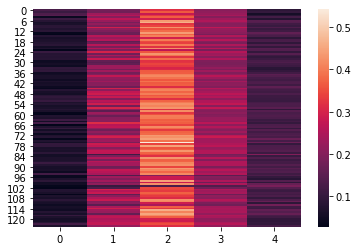

In [45]:
X = get_X_features(sourcesink_dataset, feature_name='data')

print(X.shape)

sns.heatmap(X)

In [181]:
dataset = spikes_dataset

#X_ = get_X_features(dataset, feature_name='data')
#X = add_spike_features(X_, spikes_dataset)
X = np.array(spikes_dataset['data'])
# get the y-labels 
subjects = np.array(dataset['subject'])
roots = dataset['roots']

exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = _get_exp_condition(subject, root)
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)
print(np.unique(exp_conditions))

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [182]:
y = y_enc.fit_transform(exp_conditions)
y_classes = y_enc.classes_
print(y_enc.classes_)

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [183]:
y = convert_experimental_cond_to_y(exp_conditions)
y = np.array(y)

In [184]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [185]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

In [27]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap='viridis',
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap='inferno')

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap='inferno')

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

NameError: name 'groups' is not defined

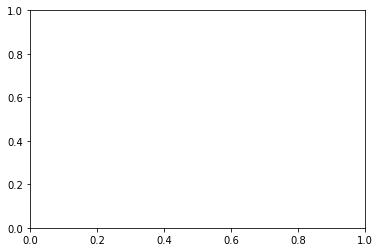

In [28]:
fig, ax = plt.subplots()
ax = plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

In [186]:
n_features = X.shape[1]
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
}

In [187]:
clf = LogisticRegression(**lr_model_params)
clf = make_pipeline(StandardScaler(), clf)

In [188]:
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=None,
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
    error_score='raise'
)

# get the estimators
estimators = scores.pop("estimator")

In [189]:
# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "train_sessions",
    "test_sessions",
    "train_tasks",
    "test_tasks",
    "train_runs",
    "test_runs",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]
    
    sessions = np.array(dataset["session"])
    tasks = np.array(dataset["task"])
    runs = np.array(dataset["run"])
    
    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    
    # append sessions
    scores["train_sessions"].append(sessions[train_inds])
    scores["test_sessions"].append(sessions[test_inds])
    
    # append tasks
    scores["train_tasks"].append(tasks[train_inds])
    scores["test_tasks"].append(tasks[test_inds])
    
    # append runs
    scores["train_runs"].append(runs[train_inds])
    scores["test_runs"].append(runs[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)[:, 1]
    
    print(f"Y_train: {y_train}")
    print(f"Y_pred: {y_pred_prob}")

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_train, y_pred_prob, n_bins=3, strategy="uniform"
    )

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)
    scores["train_fraction_pos"].append(fraction_of_positives)
    scores["train_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
    scores["train_fpr"].append(fpr)
    scores["train_tpr"].append(tpr)
    scores["train_fnr"].append(fnr)
    scores["train_tnr"].append(tnr)
    scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    print(f"Y_test: {y_test}")
    print(f"Y_pred: {y_pred_prob}")
    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=3, strategy="quantile"
    )

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

    tn, fp, fn, tp = confusion_matrix(
        y_test.astype(int), (y_pred_prob > 0.5).astype(int)
    ).ravel()
    scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
    )
    scores["test_importances"].append(r.importances)

Y_train: [1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 0 1 1]
Y_pred: [0.66578592 0.66578592 0.66578592 0.66578592 0.66578592 0.69141139
 0.66578592 0.71490892 0.9968054  0.66578592 0.66578592 0.99999953
 0.66578592 0.66578592 0.73561216 0.76308248 0.66578592 0.66578592
 0.66578592 0.66578592 0.71159191 0.69052945 0.69471364 0.66578592
 0.6931575  0.80900508 0.66578592 0.66578592 0.8291308  0.66578592
 0.66578592 0.66578592 0.9846131  0.71217531 0.66578592 0.66578592
 0.66578592 0.66578592 0.66578592 0.66578592 0.84621712 0.66578592
 0.66578592 0.6904629  0.99999744 0.67165706 0.92246013 0.66578592
 0.66578592 0.99322418 0.66578592 0.66578592 0.99051168 0.66578592
 0.66578592 0.66578592 0.66578592 0.73633412 0.73920081 0.66578592
 0.66578592 0.6781785  0.66578592 0.86450419 0.67165706 0.93569603
 0.66578592 0.99999913 0.66578592 0.66578592 0.77041831 0.66578592

[0.         0.33333334 0.66666667 1.00000001]
Y_test: [0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1]
Y_pred: [0.66778322 0.66778322 0.66778322 0.92124139 0.66778322 0.66778322
 0.66778322 0.66778322 0.99999959 0.75408434 0.66778322 0.66778322
 0.67707352 0.67507277 0.66778322 0.66778322 0.66778322 0.66778322
 0.97739265 0.66778322 0.66778322 0.66778322 0.66778322 0.66778322
 0.66778322 0.74081886 0.99999152 0.66778322 0.66778322 0.66778322
 0.69228169 0.99312589 0.66778322 0.66778322 0.74270088 0.66778322
 0.78104918 0.66778322]
[0.66778322 0.66778322 0.66778322 0.9999996 ]
Y_train: [0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 0 0]
Y_pred: [0.65734177 0.65734177 0.65734177 0.65734177 0.65734177 0.66902424
 0.65734177 0.65734177 0.65734177 0.99942932 0.65734177 0.65734177
 0.73968049 0.99998345 0.65734177 0.84219262 0.70307932 

In [190]:
clf_name = "logreg"
fname = (
    combined_deriv_dir
    / f"cv{n_splits}_{clf_name}_mtry{n_features}_exp_{exp_name}_meandiff.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Scalp_EEG_combined\cv20_logreg_mtry6_exp_spikes_jhhjeff_0.9_meandiff.json


In [191]:
with open(fname.with_suffix(".json"), "w+") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

In [192]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]
    thresh = scores[f"{which_set}_thresholds"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

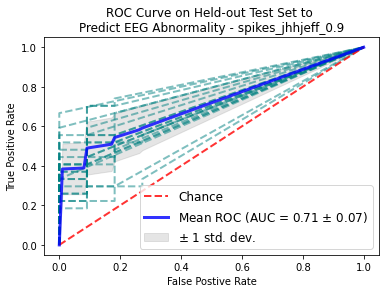

In [193]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
#fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")